In [1]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM, GRU, TimeDistributed, Bidirectional
from keras.layers import Dot, Softmax
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, MaxPool2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd
import random

In [2]:
df_target = pd.read_csv(os.path.abspath('Target_words_dataframe'))
df_unknown = pd.read_csv(os.path.abspath('Unknown_words_dataframe'))
df = pd.read_csv(os.path.abspath('full_df'))

In [3]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [7]:
filename = os.path.abspath('../../Data_spotter_mfcc_40')
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [8]:
def save_model(Model, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    Model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    model_json = Model.to_json()
    with open("model_json.json", "w") as json_file:
        json_file.write(model_json)

In [9]:
def save_model_history(model_history, model_history_name):
    filename = 'saved_models_history/' + model_history_name
    outfile = open(filename,'wb')
    pickle.dump(model_history, outfile)
    outfile.close()

In [10]:
def report(model, X, y, classes):
    model_predictions = model.predict(X).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return sklearn.metrics.classification_report(true_predictions, model_predictions, target_names=classes)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.word
                                                    , test_size=6464
                                                    , train_size = 58240
                                                    , shuffle=True
                                                    , random_state=42)

In [12]:
print(f'X_train size = {X_train.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (58240, 40, 61)
Y_train size = (58240,)
X_test size = (6464, 40, 61)
Y_test size = (6464,)


In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [14]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [15]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print(lb.classes_)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unkown' 'up' 'yes']


In [16]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(f'X_train size = {X_train.shape}')
print(f'X_test size = {X_test.shape}')

X_train size = (58240, 40, 61, 1)
X_test size = (6464, 40, 61, 1)


In [17]:
def ATT_RNN_model(input_shape, nclass):
    
    input_ = Input(input_shape)
    
    X = Convolution2D(10, (5, 1), activation="relu", dilation_rate=(1, 1), strides=(1, 1))(input_)
    X = BatchNormalization()(X)
    X = Convolution2D(1, (5, 1), activation="relu", dilation_rate=(1, 1), strides=(1, 1))(X)
    X = BatchNormalization()(X)
    shape = X.shape
    X = tf.keras.layers.Reshape((-1, shape[2] * shape[3]))(X)
    X = Bidirectional(GRU(units=128,  return_sequences=True, unroll=True))(X)
    X = Bidirectional(GRU(units=128,  return_sequences=True, unroll=True))(X)
    
    feature_dim = X.shape[-1]
    middle = X.shape[1] // 2
    mid_feature = X[:, middle, :]
    
    query = Dense(feature_dim)(mid_feature)
        
    att_weights = Dot(axes=[1, 2])([query, X])
    att_weights = Softmax(name='attSoftmax')(att_weights)
    X = Dot(axes=[1, 1])([att_weights, X])
    X = Dropout(rate=0.1)(X)
    
    X = Dense(64, activation="relu")(X)
    X = Dense(32, activation="linear")(X)
    
    output_ = Dense(nclass, activation='softmax')(X)
    
    ret_model = Model(inputs = input_, outputs=output_)
    
    return ret_model

In [18]:
model = ATT_RNN_model((40, 61, 1), len(lb.classes_))

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 61, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 36, 61, 10)   60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 36, 61, 10)   40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 61, 1)    51          batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])

In [21]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.batch(batch_size)

loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.CategoricalAccuracy()

In [22]:
epochs = 3

test_loss = []
test_acc = []
train_loss = []
train_acc = []

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))
        
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 50 batches.
        if step % 50 == 0 and step > 0:
            test_loss_acc = model.evaluate(X_test, Y_test, batch_size=64)
            train_loss_acc = float(loss_value), float(train_acc_metric.result()) 
            test_loss.append(test_loss_acc[0])
            test_acc.append(test_loss_acc[1])
            train_loss.append(train_loss_acc[0])
            train_acc.append(train_loss_acc[1])
            print("Current step: %d" % step)
            print("Test loss and acc: %.4f %.4f" % (test_loss_acc[0], test_loss_acc[1]))
            print("Training loss and acc: %.4f %.4f" % (float(train_loss_acc[0]), float(train_loss_acc[1])))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc_metric.reset_states()


Start of epoch 0
101/101 [==============================] - 7s 34ms/step - loss: 1.5861 - accuracy: 0.6425
Current step: 50
Test loss and acc: 1.6100 0.6303
Training loss and acc: 1.7239 0.6127
Seen so far: 3264 samples
101/101 [==============================] - 4s 39ms/step - loss: 1.5063 - accuracy: 0.6303
Current step: 100
Test loss and acc: 1.5063 0.6303
Training loss and acc: 1.2790 0.6282
Seen so far: 6464 samples
101/101 [==============================] - 3s 34ms/step - loss: 1.5606 - accuracy: 0.6304
Current step: 150
Test loss and acc: 1.5606 0.6304
Training loss and acc: 1.3647 0.6327
Seen so far: 9664 samples
101/101 [==============================] - 4s 36ms/step - loss: 1.4008 - accuracy: 0.6301
Current step: 200
Test loss and acc: 1.4008 0.6301
Training loss and acc: 1.1967 0.6301
Seen so far: 12864 samples
101/101 [==============================] - 4s 37ms/step - loss: 1.3460 - accuracy: 0.6341
Current step: 250
Test loss and acc: 1.3460 0.6341
Training loss and acc: 1.

In [23]:
epochs = 3

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))
        
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 50 batches.
        if step % 50 == 0 and step > 0:
            test_loss_acc = model.evaluate(X_test, Y_test, batch_size=64)
            train_loss_acc = float(loss_value), float(train_acc_metric.result()) 
            test_loss.append(test_loss_acc[0])
            test_acc.append(test_loss_acc[1])
            train_loss.append(train_loss_acc[0])
            train_acc.append(train_loss_acc[1])
            print("Current step: %d" % step)
            print("Test loss and acc: %.4f %.4f" % (test_loss_acc[0], test_loss_acc[1]))
            print("Training loss and acc: %.4f %.4f" % (float(train_loss_acc[0]), float(train_loss_acc[1])))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc_metric.reset_states()


Start of epoch 0
101/101 [==============================] - 4s 38ms/step - loss: 0.6128 - accuracy: 0.8009
Current step: 50
Test loss and acc: 0.6128 0.8009
Training loss and acc: 0.6589 0.8220
Seen so far: 3264 samples
101/101 [==============================] - 4s 38ms/step - loss: 0.6059 - accuracy: 0.8021
Current step: 100
Test loss and acc: 0.6059 0.8021
Training loss and acc: 0.4577 0.8326
Seen so far: 6464 samples
101/101 [==============================] - 4s 39ms/step - loss: 0.6080 - accuracy: 0.8017
Current step: 150
Test loss and acc: 0.6080 0.8017
Training loss and acc: 0.5867 0.8276
Seen so far: 9664 samples
101/101 [==============================] - 4s 38ms/step - loss: 0.6149 - accuracy: 0.8024
Current step: 200
Test loss and acc: 0.6149 0.8024
Training loss and acc: 0.3336 0.8282
Seen so far: 12864 samples
101/101 [==============================] - 4s 38ms/step - loss: 0.5887 - accuracy: 0.8091
Current step: 250
Test loss and acc: 0.5887 0.8091
Training loss and acc: 0.

In [17]:
opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ["accuracy"])

model_history = model.fit(x = X_train, y = Y_train, epochs = 5, batch_size = 16, validation_data=(X_test, Y_test))

Epoch 1/5
3641/3641 [==============================] - 5264s 1s/step - loss: 0.1923 - accuracy: 0.6471 - val_loss: 0.0822 - val_accuracy: 0.8293
Epoch 2/5
3641/3641 [==============================] - 4593s 1s/step - loss: 0.0688 - accuracy: 0.8599 - val_loss: 0.0570 - val_accuracy: 0.8821
Epoch 3/5
3641/3641 [==============================] - 3792s 1s/step - loss: 0.0459 - accuracy: 0.9075 - val_loss: 0.0515 - val_accuracy: 0.8971
Epoch 4/5
3641/3641 [==============================] - 3794s 1s/step - loss: 0.0368 - accuracy: 0.9269 - val_loss: 0.0518 - val_accuracy: 0.9024
Epoch 5/5
3641/3641 [==============================] - 3791s 1s/step - loss: 0.0321 - accuracy: 0.9384 - val_loss: 0.0545 - val_accuracy: 0.8996


In [18]:
model_history_1 = model.fit(x = X_train, y = Y_train, epochs = 1, batch_size = 16, validation_data=(X_test, Y_test))

3641/3641 [==============================] - 3817s 1s/step - loss: 0.0297 - accuracy: 0.9427 - val_loss: 0.0536 - val_accuracy: 0.9089


In [19]:
save_model(model, "AT_RNN")

INFO:tensorflow:Assets written to: C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\AT_RNN\assets
Save model and weights at C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\AT_RNN 


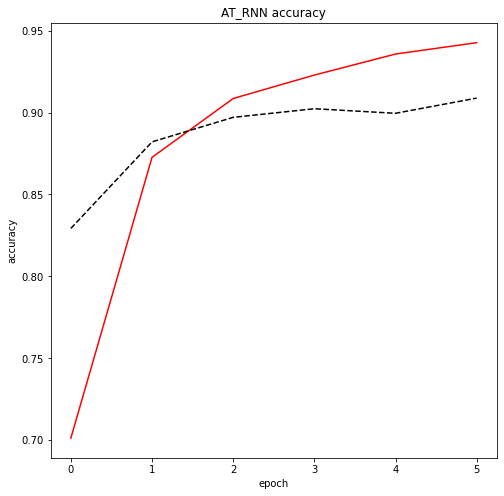

In [20]:
plt.figure(figsize=(8,8))
plt.plot(model_history.history['accuracy'] + model_history_1.history['accuracy'], 
         color="red")
plt.plot(model_history.history['val_accuracy'] + model_history_1.history['val_accuracy'], 
         color="black", 
         linestyle="dashed")
plt.title('AT_RNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("AT_RNN")
plt.show()

In [23]:
model_history.history['accuracy'] += model_history_1.history['accuracy']
model_history.history['val_accuracy'] += model_history_1.history['val_accuracy']

In [25]:
save_model_history(model_history.history, "AT_RNN")

In [26]:
print(report(model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.92      0.72      0.81       254
          go       0.85      0.78      0.81       229
        left       0.83      0.84      0.84       236
          no       0.87      0.84      0.86       242
         off       0.73      0.89      0.80       226
          on       0.89      0.74      0.81       229
       right       0.91      0.81      0.86       252
        stop       0.95      0.86      0.90       235
     unknown       0.93      0.97      0.95      4081
          up       0.85      0.78      0.81       250
         yes       0.99      0.87      0.93       239

    accuracy                           0.91      6473
   macro avg       0.88      0.83      0.85      6473
weighted avg       0.91      0.91      0.91      6473

